# Import signal

In [31]:
from qampy import signals, equalisation, phaserec, helpers, filtering
import numpy as np

In [2]:
RecSig_I = np.zeros((10000,1))
RecSig_Q = np.zeros((10000,1))

Import signal from csv file

In [3]:
import csv
I_csv_fileName = '20Gbaud_50Gsample_-11dBmSignalPower_12dBmLOPower000_Ch2.csv'
Q_csv_fileName = '20Gbaud_50Gsample_-11dBmSignalPower_12dBmLOPower000_Ch4.csv'
with open (I_csv_fileName) as I_csv_file:
    csv_reader = csv.reader(I_csv_file,delimiter=',')
    line_count = 0
    for row in csv_reader:
        RecSig_I[line_count] = row[4]
        line_count += 1
    print(f'Processed {line_count} lines.')
with open (Q_csv_fileName) as Q_csv_file:
    csv_reader = csv.reader(Q_csv_file,delimiter=',')
    line_count = 0
    for row in csv_reader:
        RecSig_Q[line_count] = row[4]
        line_count += 1
    print(f'Processed {line_count} lines.')

Processed 10000 lines.
Processed 10000 lines.


Plot received signal in time domain

Populating the interactive namespace from numpy and matplotlib


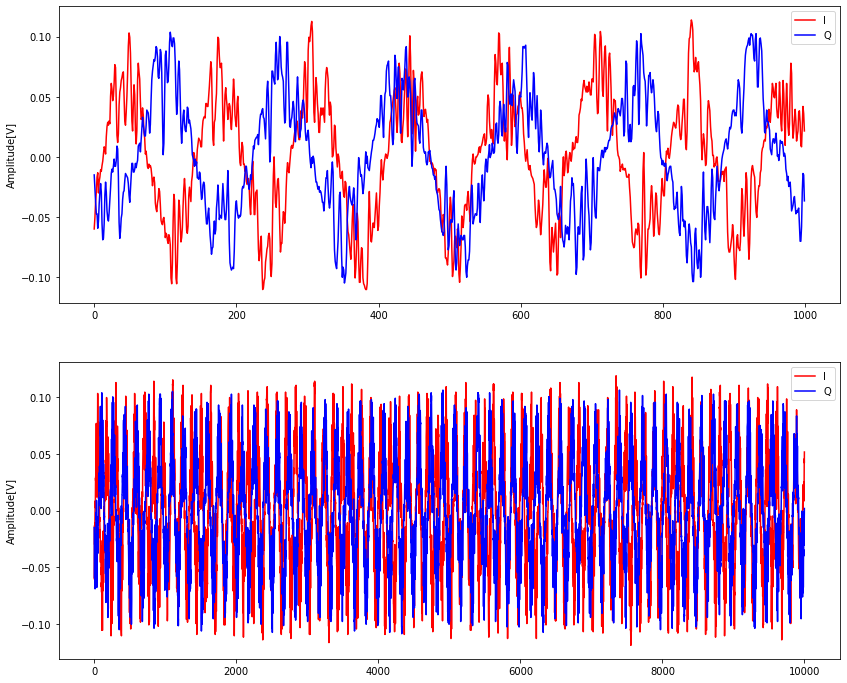

In [4]:
%pylab inline
# import matplotlib.pyplot as plt
figure(figsize=(14,12))
subplot(211)
plot(RecSig_I[0:1000],'r',label='I')
plot(RecSig_Q[0:1000],'b',label='Q')
ylabel('Amplitude[V]')
legend()
subplot(212)
plot(RecSig_I[0:10000],'r',label='I')
plot(RecSig_Q[0:10000],'b',label='Q')
ylabel('Amplitude[V]')
legend()
show()

Plot signal constellation diagram

In [5]:
# here we use bokeh for plotting as it is much faster
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show
import warnings
warnings.filterwarnings('ignore')
output_notebook()

Loading BokehJS ...

In [2]:
def plot_constellation(E):
    fig = figure(title="QPSK signal constellation", output_backend="webgl")
    fig.scatter(E[0].real, E[0].imag, color='blue', alpha=0.3, legend="X")
    fig.xaxis[0].axis_label = "In-Phase"
    fig.yaxis[0].axis_label = "Quadrature"
    show(fig)

In [7]:
RecSig = RecSig_I + 1j*RecSig_Q
RecSig = transpose(RecSig)

In [3]:
plot_constellation(RecSig)

NameError: name 'RecSig' is not defined

# Digital signal processing 

Required DSP step:
1. Normalization
2. Match filtering
3. Frequency offset compensation
4. Phase recovery

Recreate signal object from data array

In [9]:
Mysig = signals.SignalQAMGrayCoded(4, 10000, nmodes=1, fb=20e9)

In [10]:
ReRecSig = Mysig.recreate_from_np_array(RecSig,fs=50e9)

In [11]:
ReRecSig = helpers.normalise_and_center(ReRecSig)

In [12]:
plot_constellation(ReRecSig)

Resample and match filter 

In [13]:
sig = ReRecSig.resample(40e9, beta=0.1, renormalise=True)

In [14]:
plot_constellation(sig)

CMA Equalization / frequency offset / phase recovery / renormalization

In [28]:
wxy, err = equalisation.equalise_signal(sig, 2e-3, Ntaps=11,adaptive_stepsize=True)
sig_out = equalisation.apply_filter(sig,wxy)

#freq_offset = phaserec.find_freq_offset(sig_out,average_over_modes = False, fft_size = 2**15)
#sig_out = phaserec.comp_freq_offset(sig_out,freq_offset)

#sig_out, ph = phaserec.viterbiviterbi(sig_out, 11)

#sig_out = helpers.dump_edges(sig_out, 20)
sig_out = helpers.normalise_and_center(sig_out)

plot_constellation(sig_out)
# ser = sig_out.cal_ser()
# print('SER is %f'%ser)

In [33]:
fig = figure(title="Error", output_backend="webgl")
fig.line(np.arange(err[0].size), filtering.moving_average(err[0].real, 50), color='blue')
show(fig)

In [41]:
freq_offset = phaserec.find_freq_offset(sig,average_over_modes = False, fft_size = 2**15)
sig2 = phaserec.comp_freq_offset(sig,freq_offset)
f=np.linspace(-sig.fs/2, sig.fs/2, sig2[0].size, endpoint=False)
fig = figure(title="Spectrum", output_backend="webgl")
fig.line(f, 20*np.log10(abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(sig2[0]))))), color='blue')
show(fig)
print(sig.shape)

(1, 8000)


In [39]:
f=np.linspace(-50/2, 50/2, RecSig[0].size, endpoint=False)
fig = figure(title="Spectrum", output_backend="webgl")
fig.line(f, 20*np.log10(abs(np.fft.fftshift(np.fft.fft(np.fft.ifftshift(RecSig[0]))))), color='blue')
show(fig)